In [2]:
# !pip install --extra-index-url https://rospypi.github.io/simple/ rospy rosbag


Looking in indexes: https://pypi.org/simple, https://rospypi.github.io/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.4/100.4 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 10.4 MB/s eta 0:00:00
  Created wheel for gnupg: filename=gnupg-2.3.1-py3-none-any.whl size=94617 sha256=166611c7b97fe56acbd119ae5ac225d67919ba91809030af6878f666e98c8177
  Stored 

In [3]:
import rosbag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import csv

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/subset.bag"
bag = rosbag.Bag(path)

In [5]:
for topic, msg, t in bag.read_messages():
  print(msg)
  break

header: 
  seq: 75061
  stamp: 
    secs: 1697739282
    nsecs: 763176357
  frame_id: "imu"
orientation: 
  x: -0.0003352643980178982
  y: -0.02734973281621933
  z: -0.0005908077582716942
  w: 0.9996256828308105
orientation_covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
angular_velocity: 
  x: -0.0014820401556789875
  y: -0.0073815155774354935
  z: -0.0370248481631279
angular_velocity_covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
linear_acceleration: 
  x: -0.5161187052726746
  y: 0.008187455125153065
  z: -9.526483535766602
linear_acceleration_covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
bag_path = "/content/drive/MyDrive/Colab Notebooks/subset.bag"

with rosbag.Bag(bag_path, 'r') as bag:
    with open('gps_data.csv', 'w', newline='') as gps_csv, \
         open('imu_data.csv', 'w', newline='') as imu_csv:

        gps_writer = csv.writer(gps_csv)
        imu_writer = csv.writer(imu_csv)

        gps_writer.writerow(['time', 'latitude', 'longitude'])
        imu_writer.writerow(['time', 'linear_acceleration.x', 'linear_acceleration.y', 'angular_velocity.z'])

        for topic, msg, t in bag.read_messages(topics=['/gps/fix', '/imu/imu_uncompensated']):
            if topic == '/gps/fix':
                gps_data = [t.to_sec(), msg.latitude, msg.longitude]
                gps_writer.writerow(gps_data)
            elif topic == '/imu/imu_uncompensated':
                imu_data = [t.to_sec(), msg.linear_acceleration.x, msg.linear_acceleration.y, msg.angular_velocity.z]
                imu_writer.writerow(imu_data)

print("CSV extraction complete.")


KeyboardInterrupt: ignored

In [6]:
gps_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/gps_data.csv')
gps_data = gps_data[['latitude', 'longitude']].dropna().values

imu_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/imu_data.csv')
imu_data = imu_data[['linear_acceleration.x', 'linear_acceleration.y', 'angular_velocity.z']].values

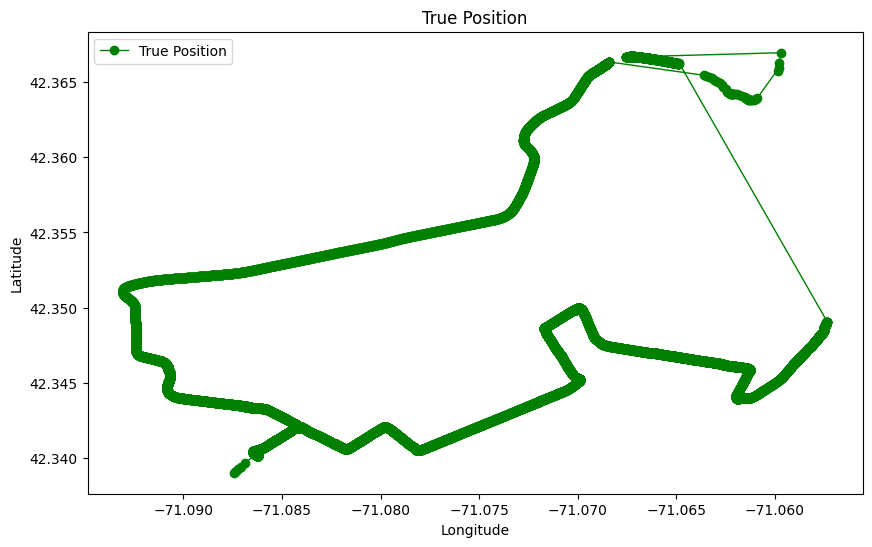

In [9]:
# From piazza post, Satvik
def plot_data(x, y, label, color, marker=None, linestyle=None, linewidth=1):
    plt.figure(figsize=(10, 6))
    if marker:
        plt.scatter(y, x, label=label, color=color, marker=marker, s=linewidth)
    else:
        plt.plot(y, x, label=label, color=color, linestyle=linestyle,marker = 'o', linewidth=linewidth)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(label)
    plt.legend()

plot_data(gps_data[:, 0], gps_data[:, 1], 'True Position', 'green', linestyle='-', linewidth=1)

plt.show()


In [10]:
def state_prediction(current_state, state_covariance, state_transition, process_noise):
    predicted_state = state_transition.dot(current_state)
    predicted_covariance = state_transition.dot(state_covariance).dot(state_transition.T) + process_noise
    return predicted_state, predicted_covariance

def measurement_correction(predicted_state, predicted_covariance, measurement, measurement_matrix, measurement_noise_covariance):
    kalman_gain = np.dot(np.dot(predicted_covariance, measurement_matrix.T), np.linalg.inv(np.dot(np.dot(measurement_matrix, predicted_covariance), measurement_matrix.T) + measurement_noise_covariance))
    measurement_residual = measurement - np.dot(measurement_matrix, predicted_state)
    state_update = np.dot(kalman_gain, measurement_residual)
    updated_state = predicted_state + state_update
    kalman_gain_matrix = np.dot(kalman_gain, measurement_matrix)
    covariance_update = np.dot(kalman_gain_matrix, predicted_covariance)
    updated_covariance = np.dot((np.eye(len(predicted_state)) - kalman_gain_matrix), predicted_covariance)
    return updated_state, updated_covariance


In [11]:
def kalman_filter(gps_data, imu_data):
    try:
        initial_state = np.array([gps_data[0, 0], gps_data[0, 1], 0])
        temp_matrix = np.eye(3) * 1e-4
        initial_covariance = temp_matrix
        process_noise_covariance = temp_matrix
        imu_measurement_noise_covariance = np.eye(3) * 1e-2
        gps_measurement_noise_covariance = np.eye(2) * 1e-2
        state_transition_matrix = np.eye(3)
        current_state, current_covariance = initial_state, initial_covariance
        gps_measurement_matrix = np.array([[1, 0, 0], [0, 1, 0]])
        imu_measurement_matrix = np.array([[0, 0, 1], [0, 0, 0], [0, 0, 0]])
        dead_reckoning_positions, kalman_estimated_positions, observed_gps = [], [], []

        for i in range(len(gps_data)):
            try:
                observed_gps.append(gps_data[i])
                if i == 0:
                    dead_reckoning_positions.append(gps_data[i])
                else:
                    time_step = 1
                    dead_reckoning_positions.append(dead_reckoning_positions[-1] + imu_data[i, :2] * time_step)
                current_state, current_covariance = state_prediction(current_state, current_covariance, state_transition_matrix, process_noise_covariance)
                current_state, current_covariance = measurement_correction(current_state, current_covariance, gps_data[i], gps_measurement_matrix, gps_measurement_noise_covariance)
                current_state, current_covariance = measurement_correction(current_state, current_covariance, imu_data[i], imu_measurement_matrix, imu_measurement_noise_covariance)
                kalman_estimated_positions.append(current_state.copy())

            except ValueError as specific_exception:
                print(f"An error occurred during data processing: {specific_exception}")

        observed_gps = np.array(observed_gps)
        dead_reckoning_positions = np.array(dead_reckoning_positions)
        kalman_estimated_positions = np.array(kalman_estimated_positions)

        return observed_gps, dead_reckoning_positions, kalman_estimated_positions

    except ValueError as another_exception:
        print(f"An error occurred in kalman_filter: {another_exception}")
        raise

raw_gps, dead_reck_pos, kalman_est_pos = kalman_filter(gps_data, imu_data)


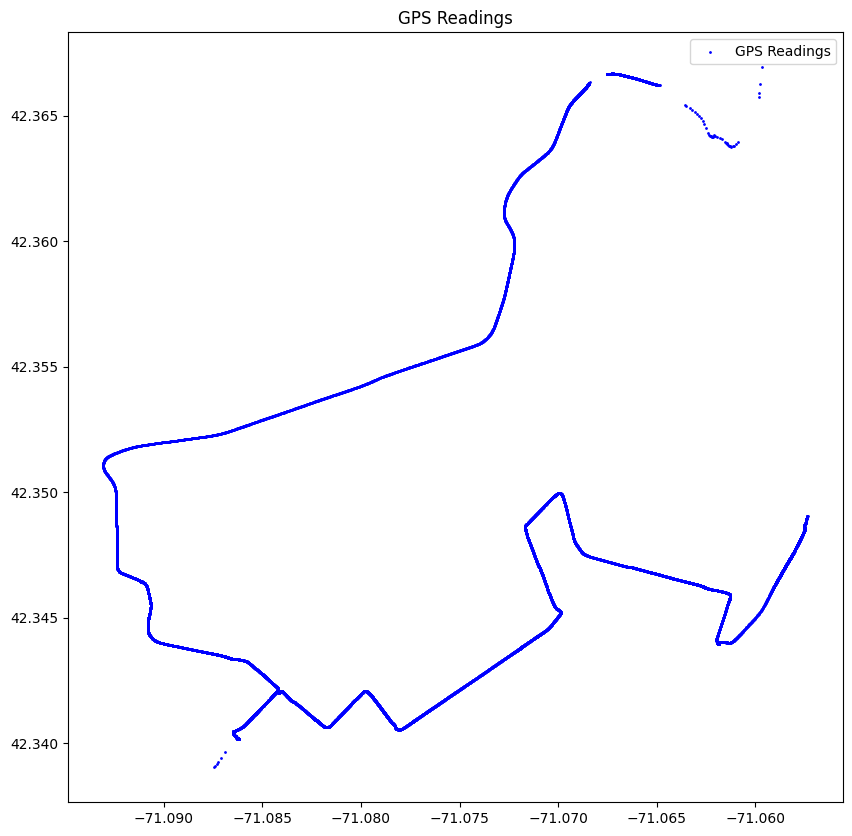

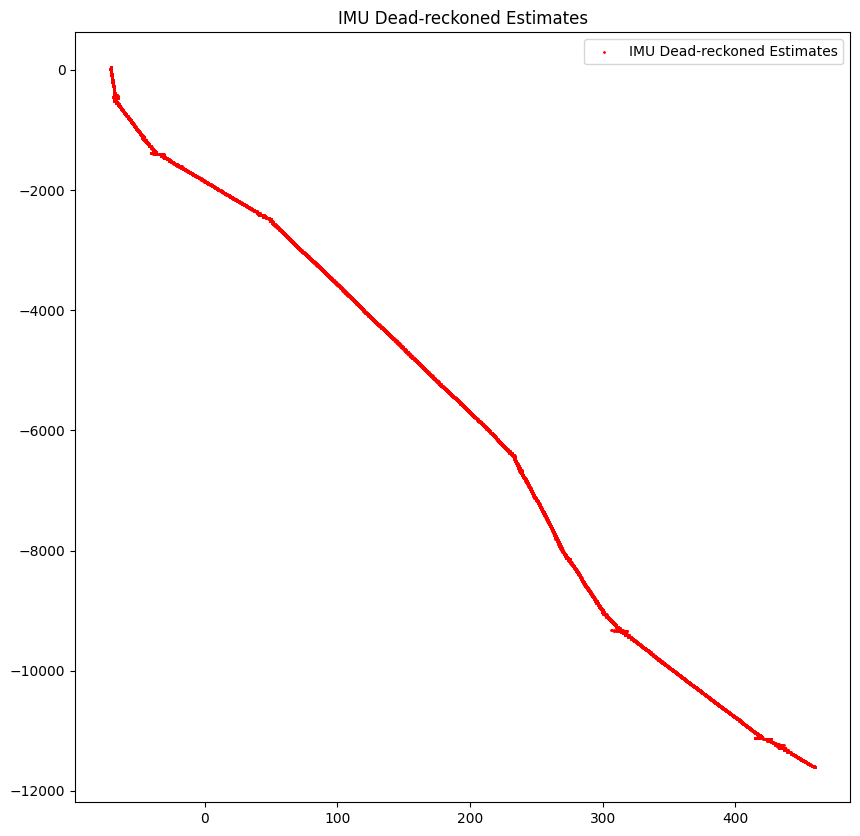

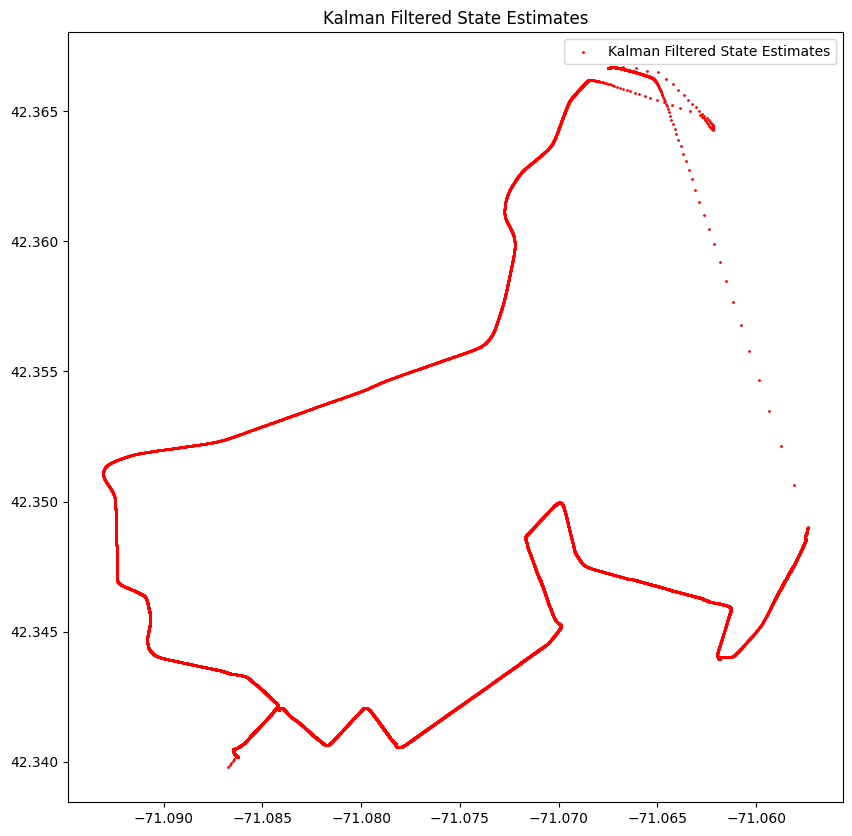

In [12]:
def scatter_plot(x, y, label, color, point_size = 1):
    plt.figure(figsize=(10, 10))
    plt.scatter(y, x, label=label, color=color, s=point_size)
    plt.title(label)
    plt.legend()
scatter_plot(raw_gps[:, 0], raw_gps[:, 1], 'GPS Readings', 'blue')
scatter_plot(dead_reck_pos[:, 0], dead_reck_pos[:, 1], 'IMU Dead-reckoned Estimates', 'red')
scatter_plot(kalman_est_pos[:, 0], kalman_est_pos[:, 1], 'Kalman Filtered State Estimates', 'red')

plt.show()


In [ ]:
def plot_on_map_plotly(raw_gps, dead_reck_pos, kalman_est_pos):
    raw_gps_df = pd.DataFrame(raw_gps, columns=["Latitude", "Longitude"])
    dead_reck_pos_df = pd.DataFrame(dead_reck_pos, columns=["Latitude", "Longitude"])
    kalman_est_pos_df = pd.DataFrame(kalman_est_pos, columns=["Latitude", "Longitude", "Location"])
    fig = px.scatter_mapbox(raw_gps_df, lat="Latitude", lon="Longitude", title="Raw GPS Readings", mapbox_style="open-street-map", zoom=15, hover_name="Latitude")
    fig.add_trace(px.scatter_mapbox(dead_reck_pos_df, lat="Latitude", lon="Longitude", title="Dead-reckoned IMU Estimates", mapbox_style="open-street-map", zoom=15, hover_name="Latitude").data[0])
    line_plot = px.line_mapbox(kalman_est_pos_df, lat="Latitude", lon="Longitude", title="Kalman Filtered State Estimates", mapbox_style="open-street-map", zoom=15, hover_name="Location")
    line_plot.data[0].line.color = "red"
    fig.add_trace(line_plot.data[0])
    fig.show()

plot_on_map_plotly(raw_gps, dead_reck_pos, kalman_est_pos)
